# Basic steps to build an image classification model using a neural network are:

1. Flatten the input image dimensions to 1D (width pixels x height pixels)
2. Normalize the image pixel values (divide by 255)
3. One-Hot Encode the categorical column
4. Build a model architecture (Sequential) with Dense layers
5. Train the model and make predictions

## *Step 1: Import Modules*

In [1]:
# !pip3 install graphviz
# !pip3 install ann_visualizer

In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
from PIL import Image
from ann_visualizer.visualize import ann_viz;

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import metrics

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline

Using TensorFlow backend.


## *Step 2: Explore Data*

In [3]:
# Adding path of all the images together 
imagePatches = glob(r'C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\**\*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1001_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1051_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1101_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1151_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1201_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1251_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1301_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1351_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1501_class0.png
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0\10253_idx5_x1001_y1551_c

(-0.5, 49.5, 49.5, -0.5)

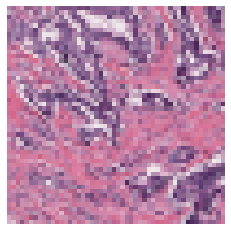

In [4]:
image_sample = r'C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12935\1\12935_idx5_x1301_y1251_class1.png'
dsize=(50,50)

image = cv2.imread(image_sample)
image = cv2.resize(image, dsize)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')

## *Step 3: Preprocess Data*

In [5]:
resized_images,labels_arr = [],[]
dsize=(50,50)
    
for img in imagePatches[0:]:
    full_size_image = cv2.imread(img)
    resized_images.append(cv2.resize(full_size_image, dsize, interpolation=cv2.INTER_CUBIC))
    labels_arr.append(int(img[-5]))

In [6]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(len(a)-np.sum(b)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(resized_images,labels_arr)

Total number of images: 277524
Number of IDC(-) Images: 198738
Number of IDC(+) Images: 78786
Image shape (Width, Height, Channels): (50, 50, 3)


- The data is scaled from 0 to 255 but we want it to be scaled from 0 to 1.
- We also want to set aside 20% of the data for testing.
- And finally, we will use an undersampling strategy to deal with the imbalanced class sizes.

In [7]:
X=np.array(resized_images)
Y=pd.Series(labels_arr) 
X=(X/255).astype('float32')
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (222019, 50, 50, 3)
Testing Data Shape: (55505, 50, 50, 3)


C:\Users\HP\anaconda3\envs\metis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Distribution of target classes'}, ylabel='count'>

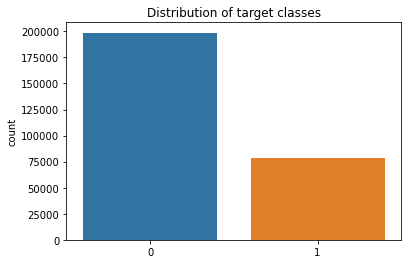

In [8]:
plt.title("Distribution of target classes")
sns.countplot(Y) 

In [9]:
# Make Data 1D for compatability upsampling methods
image_shape = 50*50*3

X_train = X_train.reshape(X_train.shape[0], image_shape)
X_test = X_test.reshape(X_test.shape[0], image_shape)

In [10]:
print("Shape of flattened training data:",X_train.shape,"\nShape of flatened testing data: ",X_test.shape)

Shape of flattened training data: (222019, 7500) 
Shape of flatened testing data:  (55505, 7500)


In [11]:
# Deal with imbalanced class sizes below

# from imblearn.over_sampling import RandomOverSampler 

from imblearn.under_sampling import RandomUnderSampler

# Ros = RandomOverSampler(sampling_strategy='auto') 
Rus = RandomUnderSampler(sampling_strategy='auto',random_state=9)

X_trainRusFlat, Y_trainRus = Rus.fit_sample(X_train, Y_train)
X_testRusFlat, Y_testRus = Rus.fit_sample(X_test, Y_test)

#Reshape the images
X_trainRus = X_trainRusFlat.reshape(len(X_trainRusFlat),50,50,3)
X_testRus = X_testRusFlat.reshape(len(X_testRusFlat),50,50,3)

# Encode labels
Y_trainRus = to_categorical(Y_trainRus, num_classes = 2)
Y_testRus = to_categorical(Y_testRus, num_classes = 2)

In [12]:
print("New shape of Train data =",X_trainRus.shape)
print("New shape of Test data =",X_testRus.shape)

New shape of Train data = (125914, 50, 50, 3)
New shape of Test data = (31658, 50, 50, 3)


## *Step 4: Building CNN Image Classification Model*

In [38]:
from numpy.random import seed
import tensorflow as tf
seed(1)
tf.random.set_seed(9)

In [39]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50,50, 3)))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.2))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(128, activation='relu'))

# output layer
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [40]:
# looking at the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

## *Step 4: Evaluation Metrics*

In [41]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## *Step 5: Train Model*

In [42]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
             metrics= [metrics.BinaryAccuracy(name='accuracy'),
                        metrics.AUC(name='auc'),
                        precision_m, recall_m, f1])

In [43]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [44]:
history = model.fit(X_trainRus, Y_trainRus, batch_size=100, epochs=100, validation_data=(X_testRus, Y_testRus)
                   ,callbacks=[es])

Epoch 1/100
1260/1260 [==============================] - 150s 119ms/step - loss: 0.4834 - accuracy: 0.7709 - auc: 0.8189 - precision_m: 0.7534 - recall_m: 0.8411 - f1: 0.7901 - val_loss: 0.4221 - val_accuracy: 0.8093 - val_auc: 0.8893 - val_precision_m: 0.7933 - val_recall_m: 0.8372 - val_f1: 0.8146
Epoch 2/100
1260/1260 [==============================] - 149s 118ms/step - loss: 0.4333 - accuracy: 0.8078 - auc: 0.8789 - precision_m: 0.7979 - recall_m: 0.8249 - f1: 0.8110 - val_loss: 0.4179 - val_accuracy: 0.8114 - val_auc: 0.8873 - val_precision_m: 0.7953 - val_recall_m: 0.8397 - val_f1: 0.8167
Epoch 3/100
1260/1260 [==============================] - 147s 117ms/step - loss: 0.4222 - accuracy: 0.8130 - auc: 0.8846 - precision_m: 0.8058 - recall_m: 0.8250 - f1: 0.8151 - val_loss: 0.3960 - val_accuracy: 0.8252 - val_auc: 0.9013 - val_precision_m: 0.8137 - val_recall_m: 0.8436 - val_f1: 0.8283
Epoch 4/100
1260/1260 [==============================] - 149s 119ms/step - loss: 0.4131 - accurac

In [45]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'precision_m', 'recall_m', 'f1', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision_m', 'val_recall_m', 'val_f1'])


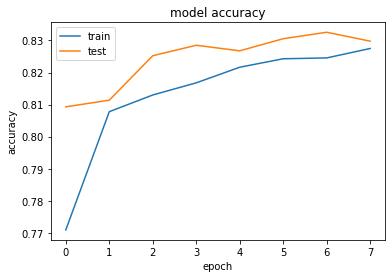

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

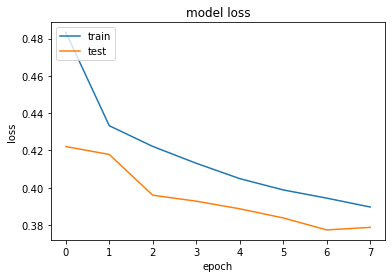

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## *Step 6: Evaluation*

In [48]:
print(model.metrics_names)

['loss', 'accuracy', 'auc', 'precision_m', 'recall_m', 'f1']


In [49]:
(loss, accuracy, auc, precision, recall, f1) = model.evaluate(X_testRus, Y_testRus)

print("Our log-loss is {}".format(loss))
print("Our accuracy is {}".format(accuracy))
print("Our auc_score is {}".format(auc))
print("Our precision is {}".format(precision))
print("Our recall is {}".format(recall))
print("Our f1-score is {}".format(f1))

990/990 [==============================] - 14s 14ms/step - loss: 0.3788 - accuracy: 0.8298 - auc: 0.9061 - precision_m: 0.8386 - recall_m: 0.8177 - f1: 0.8274
Our log-loss is 0.37876397371292114
Our accuracy is 0.8297902345657349
Our auc_score is 0.9060633182525635
Our precision is 0.8385530710220337
Our recall is 0.8176641464233398
Our f1-score is 0.8273536562919617


### Confusion Matrix

In [50]:
# Predicting the Test set results
y_pred = model.predict(X_testRus)
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

In [51]:
print('\n', classification_report(np.where(Y_testRus > 0)[1], np.argmax(y_pred, axis=1), 
                                      target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
    
Y_true = np.argmax(Y_testRus,axis=1) 


              precision    recall  f1-score   support

      IDC(-)       0.83      0.85      0.84     15829
      IDC(+)       0.85      0.82      0.83     15829

    accuracy                           0.84     31658
   macro avg       0.84      0.84      0.84     31658
weighted avg       0.84      0.84      0.84     31658



In [52]:
def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Blues):
    title='Confusion matrix'
    classes = {0: 'IDC(-)', 1: 'IDC(+)'}
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

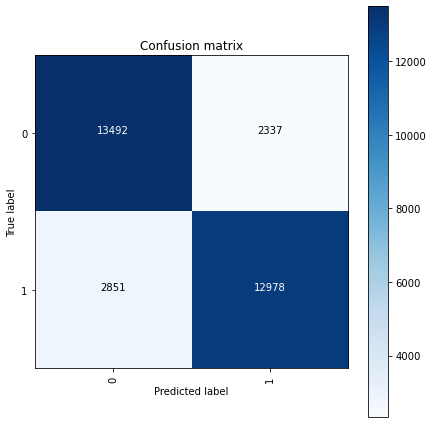

In [53]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx) 
plt.show()

### Test Case 1

In [54]:
#function to plot image
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])  

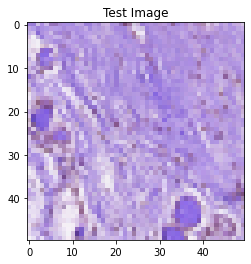

In [55]:
index1 = 51
img_plot(X_testRus, index1)

In [56]:
input1 = X_testRus[index1:index1+1]
print('Input Index =',index1)

Input Index = 51


In [57]:
label1 = Y_testRus[index1].argmax()
pred1 = model.predict(input1)[0].argmax()

print('Predicted Value using cnn model',pred1)

print("\nTrue Value",label1)

Predicted Value using cnn model 0

True Value 0


### Test Case 2

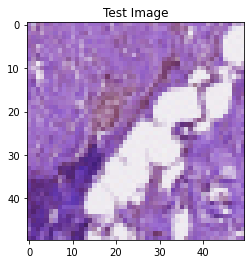

In [58]:
index2 = 402
img_plot(X_testRus, index2)

In [59]:
input2 = X_testRus[index2:index2+1]
print('Input Index =',index2)

Input Index = 402


In [60]:
label2 = Y_testRus[index2].argmax()
pred2 = model.predict(input2)[0].argmax()

print('Predicted Value using cnn model',pred2)

print("\nTrue Value",label2)

Predicted Value using cnn model 0

True Value 0
